In [1]:
import os
import numpy as np
import scipy.ndimage
import skimage.feature
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
bgr_imgs = [cv2.imread(f'imgs/{name}', cv2.IMREAD_COLOR) for name in sorted(os.listdir('imgs'))]
gray_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in bgr_imgs]

In [163]:
imgs_bboxes = {0: [[(37, 117), (179,130)],
                  [(480, 115), (579, 128)],
                  [(27, 144), (324, 185)],
                  [(27, 185), (263, 216)],
                  [(25, 253), (241, 568)],
                  [(249, 253), (465, 570)],
                  [(476, 251), (700, 465)],
                  [(685, 454), (694, 462)],
                  [(475, 475), (695, 499)],
                  [(475, 505), (694, 575)],
                  [(31, 579), (345, 631)],
                  [(366, 581), (689, 634)]],
               
               1: [[(6, 21), (46, 73)],
                  [(49, 18), (96, 73)],
                  [(101, 17), (159, 71)],
                  [(165, 15), (223, 71)],
                  [(228, 12), (273, 69)],
                  [(278, 7), (323, 68)],
                  [(327, 9), (362, 66)],
                  [(365, 9), (408, 64)],
                  [(409, 8), (457, 63)],
                  [(454, 7), (495, 62)],
                  [(498, 5), (534, 59)],
                  [(538, 4), (587, 60)],
                  [(593, 0), (640, 55)],
                  [(644, 0), (694, 55)],
                  [(7, 79), (122, 98)],
                  [(520, 66), (583, 82)],
                  [(585, 62), (640, 80)],
                  [(643, 59), (690, 76)],
                  [(326, 73), (376, 127)],
                  [(377, 71), (423, 125)],
                  [(425, 70), (484, 123)],
                  [(282, 76), (304, 89)],
                  [(305, 74), (337, 89)],
                  [(124, 467), (510, 516)],
                  [(514, 483), (580, 513)],
                  [(122, 518), (583, 590)],
                  [(166, 590), (541, 665)],
                  [(143, 818), (566, 845)],
                  [(171, 842), (534, 869)],
                  [(213, 866), (507, 893)],
                  [(326, 900), (401, 933)],
                  [(571, 909), (657, 937)]],
               
              2: [[(0, 20), (9, 36)],
                 [(17, 0), (417, 61)],
                 [(0, 82), (7, 100)],
                 [(23, 81), (57, 110)],
                 [(57, 80), (131, 100)],
                 [(129, 65), (302, 94)],
                 [(21, 111), (136, 131)],
                 [(135, 94), (395, 125)],
                 [(23, 129), (132, 158)],
                 [(130, 125), (190, 150)],
                 [(6, 202), (427, 703)],
                 [(99, 804), (313, 833)],
                 [(65, 831), (357, 873)],
                 [(86, 891), (335, 936)]],
               
              3: [[(40, 116), (942, 362)],
                 [(48, 360), (921, 721)],
                 [(29, 82), (67, 113)],
                 [(81, 59), (277, 102)]], 
               
              4: [[(33, 16), (671, 193)],
                 [(35, 212), (667, 411)],
                 [(37, 424), (675, 567)],
                 [(41, 595), (655, 724)],
                 [(46, 738), (665, 824)],
                 [(48, 823), (399, 925)],
                 [(527, 876), (695, 936)],
                 [(533, 941), (685, 955)]],
               
              5: [[(7, 16), (492, 703)],
                 [(492, 26), (959, 703)]]
         
}

In [164]:
imgs_out = []
for img, (k, bboxes) in zip(gray_imgs, imgs_bboxes.items()):
    img_out = 255*np.ones_like(img)
    for bbox in bboxes:
        text = img[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
        _, thr = cv2.threshold(text, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        if thr.mean() < 127:
            thr = 255 - thr
        """
        if text.mean() < 127:
            text = 255 - text
        thr = cv2.adaptiveThreshold(text, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 1)
        """   
        img_out[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] = thr
        #plt.imshow(thr, cmap='gray')
        #plt.show()
    
    imgs_out.append(img_out)

In [165]:
def get_text(decision_boundary=127, max_value=255, flip_value=127):
    imgs_out = []
    for img, (k, bboxes) in zip(gray_imgs, imgs_bboxes.items()):
        img_out = 255*np.ones_like(img)
        for bbox in bboxes:
            text = img[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
            _, thr = cv2.threshold(text, decision_boundary, max_value, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
            if thr.mean() < flip_value:
                thr = 255 - thr
            img_out[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] = thr
        imgs_out.append(img_out)
    
    plt.figure(figsize=(15,15))
    for k, img in enumerate(imgs_out):
        plt.subplot(3,2,k+1)
        plt.imshow(img, cmap='gray')
    
plot_text = interactive(get_text, decision_boundary=(0, 255, 1), max_value=(0, 255, 1), flip_value=(0, 255, 1))
plot_text

interactive(children=(IntSlider(value=127, description='decision_boundary', max=255), IntSlider(value=255, des…

In [166]:
def get_text(block_size=11, C=1, flip_value=127):
    imgs_out = []
    for img, (k, bboxes) in zip(gray_imgs, imgs_bboxes.items()):
        img_out = 255*np.ones_like(img)
        for bbox in bboxes:
            text = img[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
            if text.mean() < flip_value:
                text = 255 - text
            thr = cv2.adaptiveThreshold(text, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C)
            img_out[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] = thr
        imgs_out.append(img_out)
    
    plt.figure(figsize=(15,30))
    for k, img in enumerate(imgs_out):
        plt.subplot(3,2,k+1)
        plt.imshow(img, cmap='gray')
    
plot_text = interactive(get_text, block_size=(1, 31, 1), C=(0.1, 20., 0.1), flip_value=(0, 255, 1))
plot_text

interactive(children=(IntSlider(value=11, description='block_size', max=31, min=1), FloatSlider(value=1.0, des…

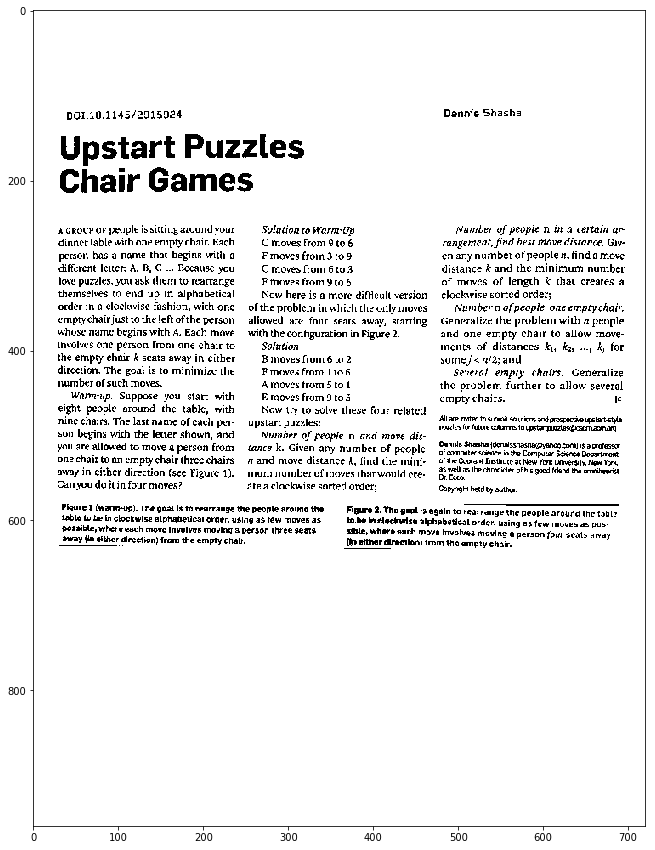

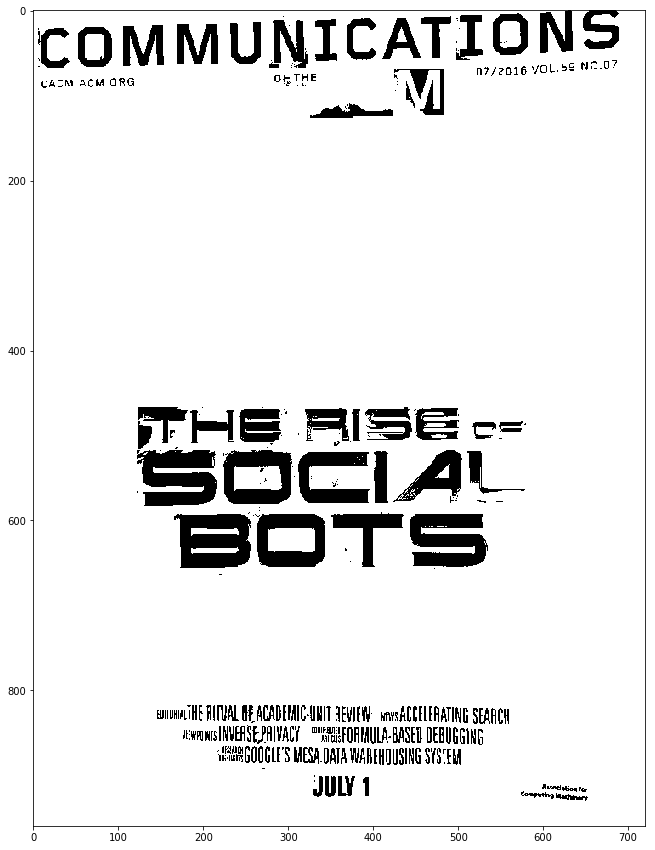

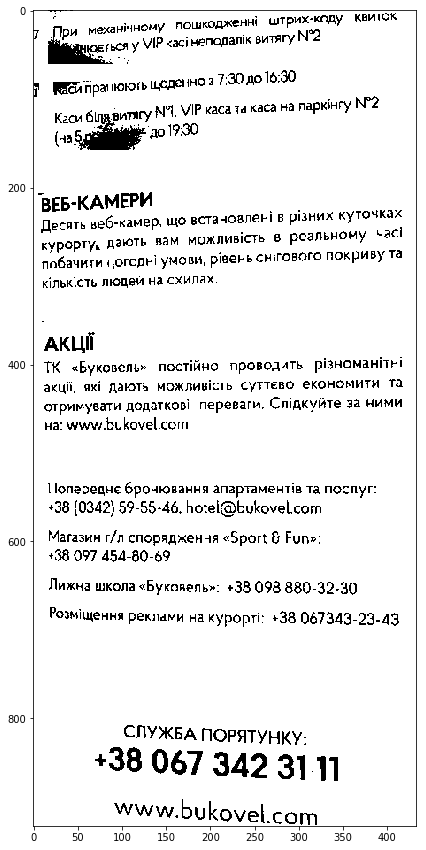

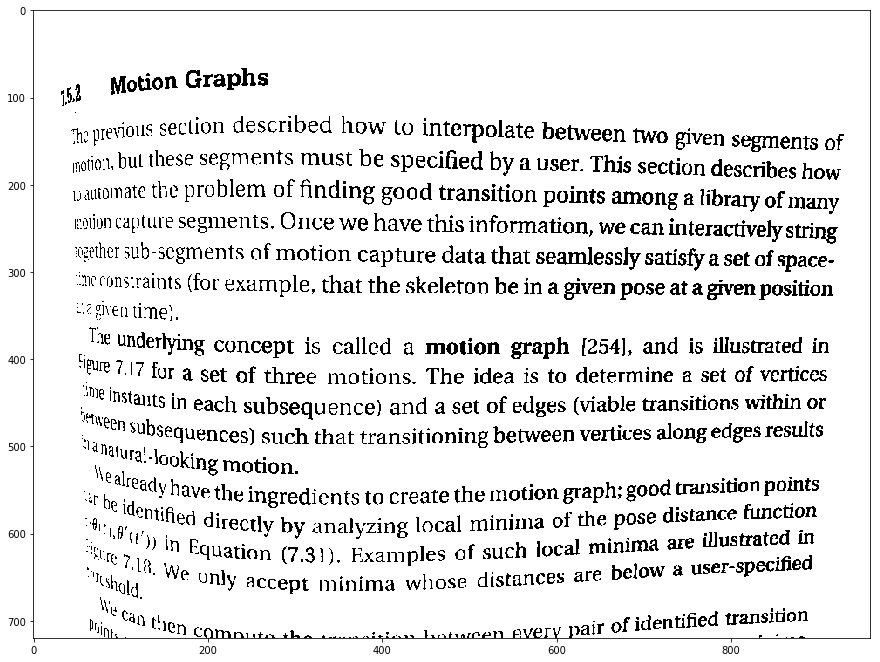

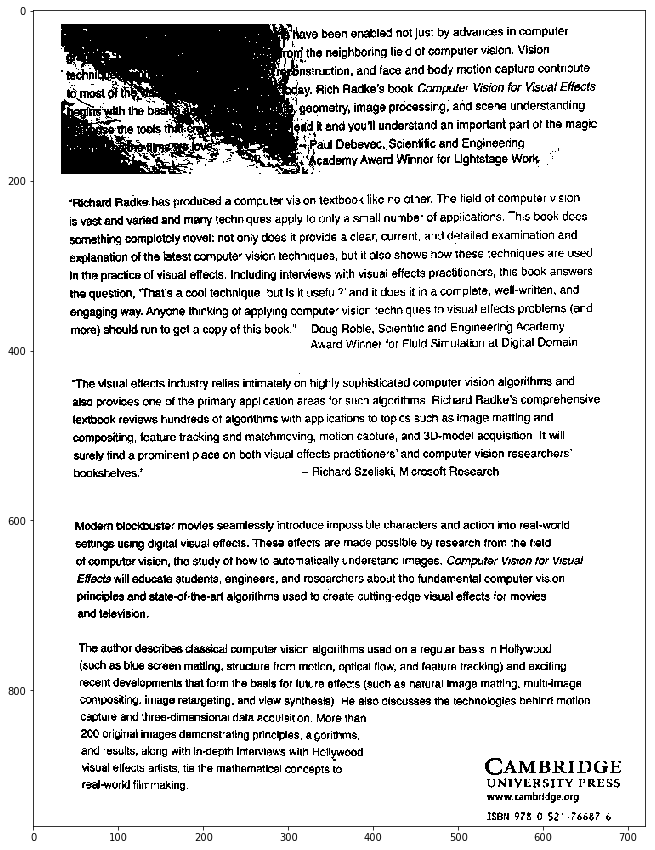

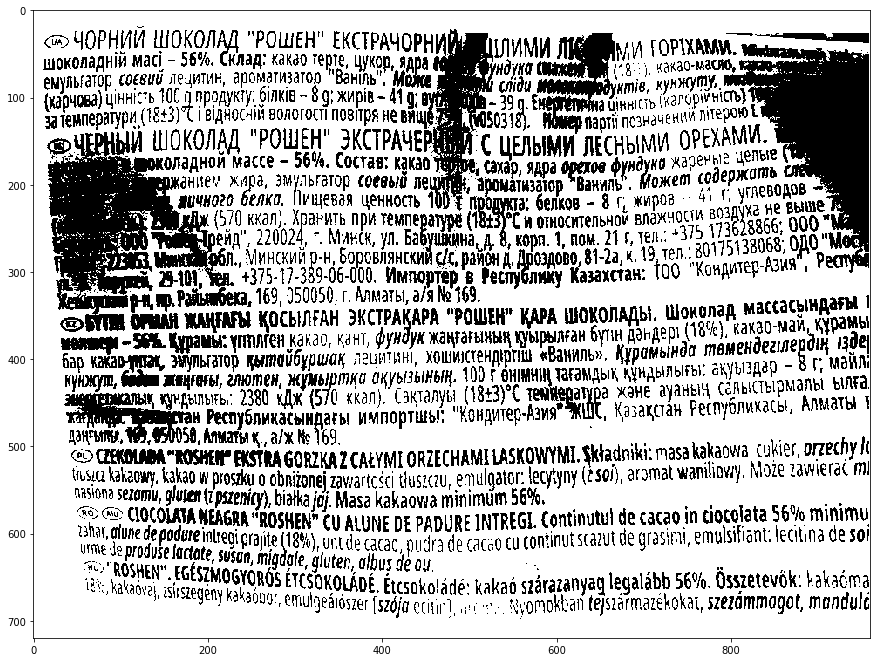

In [153]:
for img in imgs_out:
    plt.figure(figsize=(15,15))
    plt.imshow(img, cmap='gray')
    plt.show()

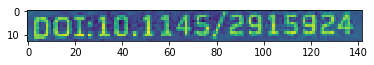

In [53]:
plt.imshow(img[bbox[0][0][1]:bbox[0][1][1],bbox[0][0][0]:bbox[0][1][0]])

In [30]:
th = [cv2.threshold(img, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) for img in gray_imgs]

In [36]:
th = [cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 5) for img in gray_imgs]

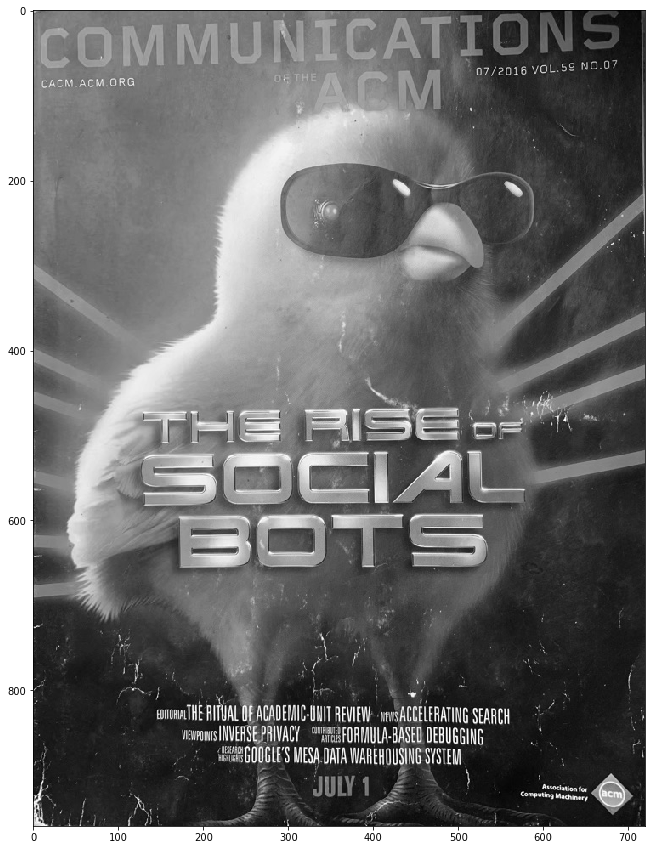

In [93]:
plt.figure(figsize=(15,15))
plt.imshow(gray_imgs[1], cmap='gray')

In [37]:
output = cv2.connectedComponents(th[0])

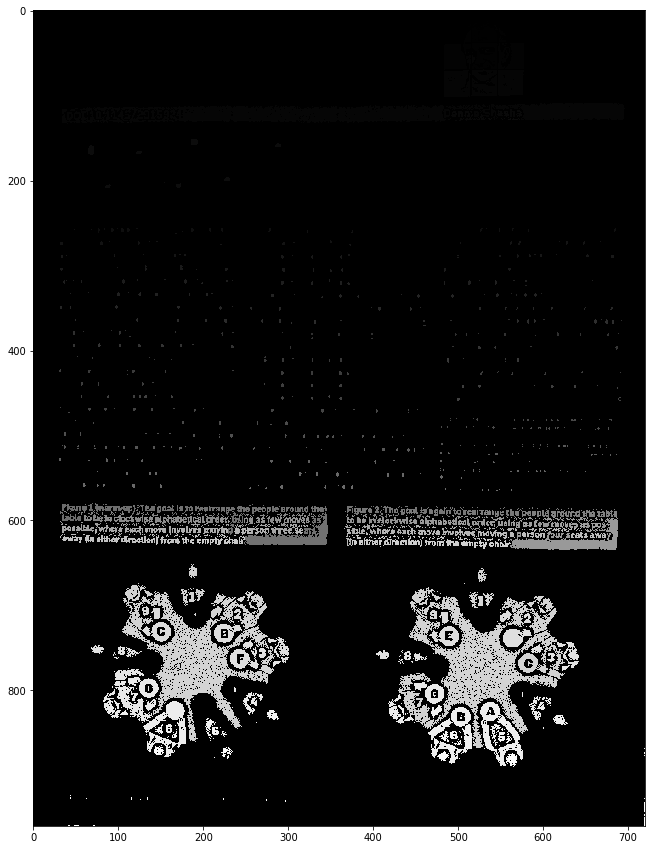

In [38]:
plt.figure(figsize=(15,15))
plt.imshow(output[1], cmap='gray')